# Final Scenario Discovery

This notebook is used to plot simulation results of 12 searched policies and 1 policy obtained from the debate. The core function is to find the tipping points for each policy.

## 0 Setup

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
######## Problem Formulation
pf = 7

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

In [3]:
# Load Results
results = load_results(f'results/robustness_results.tar.gz')

# Extracting the results
experiments, outcomes = results

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\robustness_results.tar.gz


In [4]:
# Group experiments and outcomes by 'policy' column
policy_groups = experiments.groupby('policy')

# Create lists to store separated datasets
experiments_list = []
outcomes_list = []

for policy, group in policy_groups:
    # drop levers
    group.drop(columns=list(model.levers.keys()), inplace=True, errors='ignore')
    group.drop(columns=["policy", "scenario", "model"], inplace=True, errors='ignore')

    # Store experiments for this policy
    experiments_list.append(group)

    # Store outcomes for this policy
    indices = group.index
    policy_outcomes = {k: v[indices] for k, v in outcomes.items()}
    outcomes_list.append(policy_outcomes)

C:\Users\Move\AppData\Local\Temp\ipykernel_12300\2754433037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  policy_groups = experiments.groupby('policy')


## 1 Discover worst case scenarios / tipping points

Apply scenario discovery, focussing on (manually) finding the tipping point or the first percentile that has Expected Annual Damage > 0.

In [5]:
list(model.outcomes.keys())

['A.4_Total Costs',
 'A.4_Dike Investment Costs',
 'A.4_Expected Annual Damage',
 'A.4_Expected Number of Deaths',
 'A.5_Total Costs',
 'A.5_Dike Investment Costs',
 'A.5_Expected Annual Damage',
 'A.5_Expected Number of Deaths',
 'RfR Total Costs',
 'Expected Evacuation Costs']

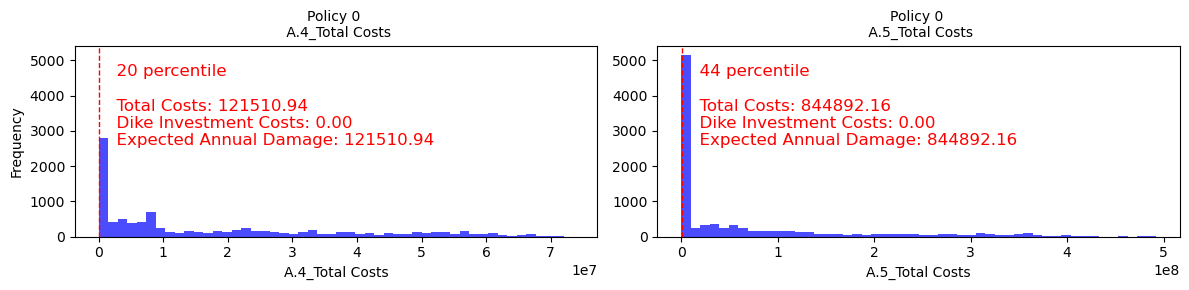

[MainProcess/INFO] 9728 points remaining, containing 7772 cases of interest
c:\Users\Move\anaconda3\envs\abm24\Lib\site-packages\ema_workbench\analysis\prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.48355263157894735, coverage: 0.6052496139989707, density: 1.0 restricted_dimensions: 4
[MainProcess/INFO] 9728 points remaining, containing 5442 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.22512335526315788, coverage: 0.402425578831312, density: 1.0 restricted_dimensions: 4


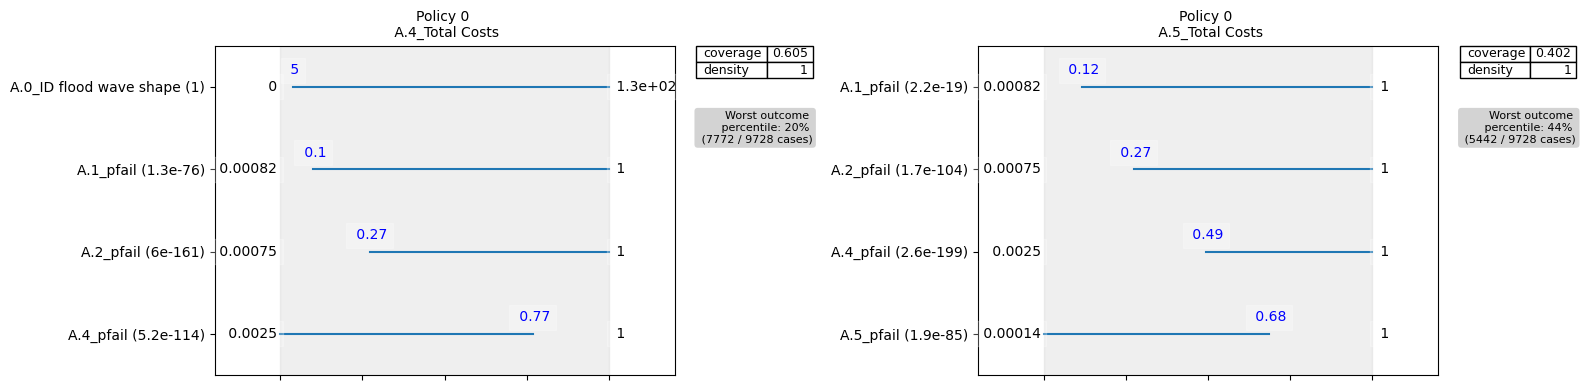

In [6]:
## show all result: Expected Number of Deaths

from ema_workbench.analysis import prim

# plot detail
dike_names = ['A.4', 'A.5']  # Dike names corresponding to the outcomes

dike_percentile = [20, 44]  # Percentiles for worst case analysis
dike_thresholds = 0.3 # Thresholds for PRIM analysis
policy_idx = 0  # Index of the policy to analyze

# Plot histograms with the same y-axis limits for both subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
hist_max = 0
# First, find the maximum y value across all histograms
for i in range(len(axes)):
    outcome_name = dike_names[i] + '_Total Costs'
    data = outcomes_list[policy_idx][outcome_name]
    counts, _ = np.histogram(data, bins=50)
    hist_max = max(hist_max, counts.max())

for i, ax in enumerate(axes):
    outcome_name = dike_names[i] + '_Total Costs'
    data = outcomes_list[policy_idx][outcome_name]
    data_2 = outcomes_list[policy_idx][dike_names[i] + '_Dike Investment Costs']
    data_3 = outcomes_list[policy_idx][dike_names[i] + '_Expected Annual Damage']
    ax.hist(data, bins=50, color='blue', alpha=0.7)
    ax.axvline(np.percentile(data, dike_percentile[i]), color='red', linestyle='dashed', linewidth=1)
    ax.annotate(f"  {dike_percentile[i]} percentile \n\n  Total Costs: {np.percentile(data, dike_percentile[i]):.2f} \n  Dike Investment Costs: {np.percentile(data_2, dike_percentile[i]):.2f} \n  Expected Annual Damage: {np.percentile(data_3, dike_percentile[i]):.2f}", 
                xy=(np.percentile(data, dike_percentile[i]), hist_max * 0.95), 
                xytext=(5, 0), textcoords='offset points',
                color='red', fontsize=12, va='top', ha='left', rotation=0)
    ax.set_title(f'Policy {policy_idx} \n {outcome_name}', fontsize=10)
    ax.set_xlabel(outcome_name)
    if i == 0:
        ax.set_ylabel('Frequency')
    ax.set_ylim(0, hist_max * 1.05)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
for i, ax in enumerate(axes):
    outcome_name = dike_names[i] + '_Total Costs'
    data = outcomes_list[policy_idx][outcome_name]
    y = data > np.percentile(data, dike_percentile[i])
    prim_alg = prim.Prim(experiments_list[policy_idx], y, threshold=dike_thresholds, peel_alpha=0.05)
    box = prim_alg.find_box()
    box.inspect(style='graph', ax=ax)
    ax.set_title(f'Policy {policy_idx} \n {outcome_name}', fontsize=10)
    # add annotation of dike threshold and dike percentile on the right side of the plot
    ax.annotate(f'Worst outcome \n percentile: {dike_percentile[i]}% \n ({np.sum(y)} / {len(data)} cases)', 
                xy=(1.3, 0.7), xycoords='axes fraction', 
                fontsize=8, ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='None', facecolor='lightgrey'))
plt.tight_layout()
plt.show()